# SARIMA Model for Electricity Demand Forecasting

## Dataset: Germany Electricity Load (2015-2018)

This notebook implements a Seasonal ARIMA (SARIMA) model for short-term electricity demand forecasting using the processed dataset from preprocessing.ipynb.


## Step 1: Import Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Statsmodels for SARIMA
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For auto_arima (if available)
try:
    from pmdarima import auto_arima
    AUTO_ARIMA_AVAILABLE = True
except ImportError:
    AUTO_ARIMA_AVAILABLE = False

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directories if they don't exist
import os
os.makedirs('../../saved_model_outputs/sarima_outputs', exist_ok=True)


## Step 2: Load and Prepare Data


In [18]:
# Load processed dataset from preprocessing notebook
try:
    from google.colab import files
    import io
    uploaded = files.upload()
    uploaded_filename = list(uploaded.keys())[0]
    df = pd.read_csv(io.BytesIO(uploaded[uploaded_filename]), parse_dates=[0], index_col=0)
except ImportError:
    data_path = '../processed_data_60min/processed_data_60min.csv'
    df = pd.read_csv(data_path, parse_dates=[0], index_col=0)

# Extract target variable (renamed in preprocessing)
target_col = 'target_load'
ts = df[target_col].copy()

# Set explicit frequency to avoid warnings (hourly data)
if ts.index.freq is None:
    inferred_freq = pd.infer_freq(ts.index)
    if inferred_freq:
        ts.index.freq = inferred_freq
    else:
        ts.index.freq = 'H'

print(f"Shape: {df.shape}")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")
print(f"Missing values: {ts.isnull().sum()}")
print(ts.describe())


Shape: (32688, 83)
Date range: 2015-01-08 00:00:00+00:00 to 2018-09-30 23:00:00+00:00
Missing values: 0
count    32688.000000
mean     55697.944169
std      10025.699743
min      31307.000000
25%      47179.750000
50%      55368.000000
75%      64719.250000
max      77549.000000
Name: target_load, dtype: float64


## Step 3: Train-Test Split


Training samples: 26,136
Test samples: 6,552
Mean shift: 1097.33 MW (1.98%)


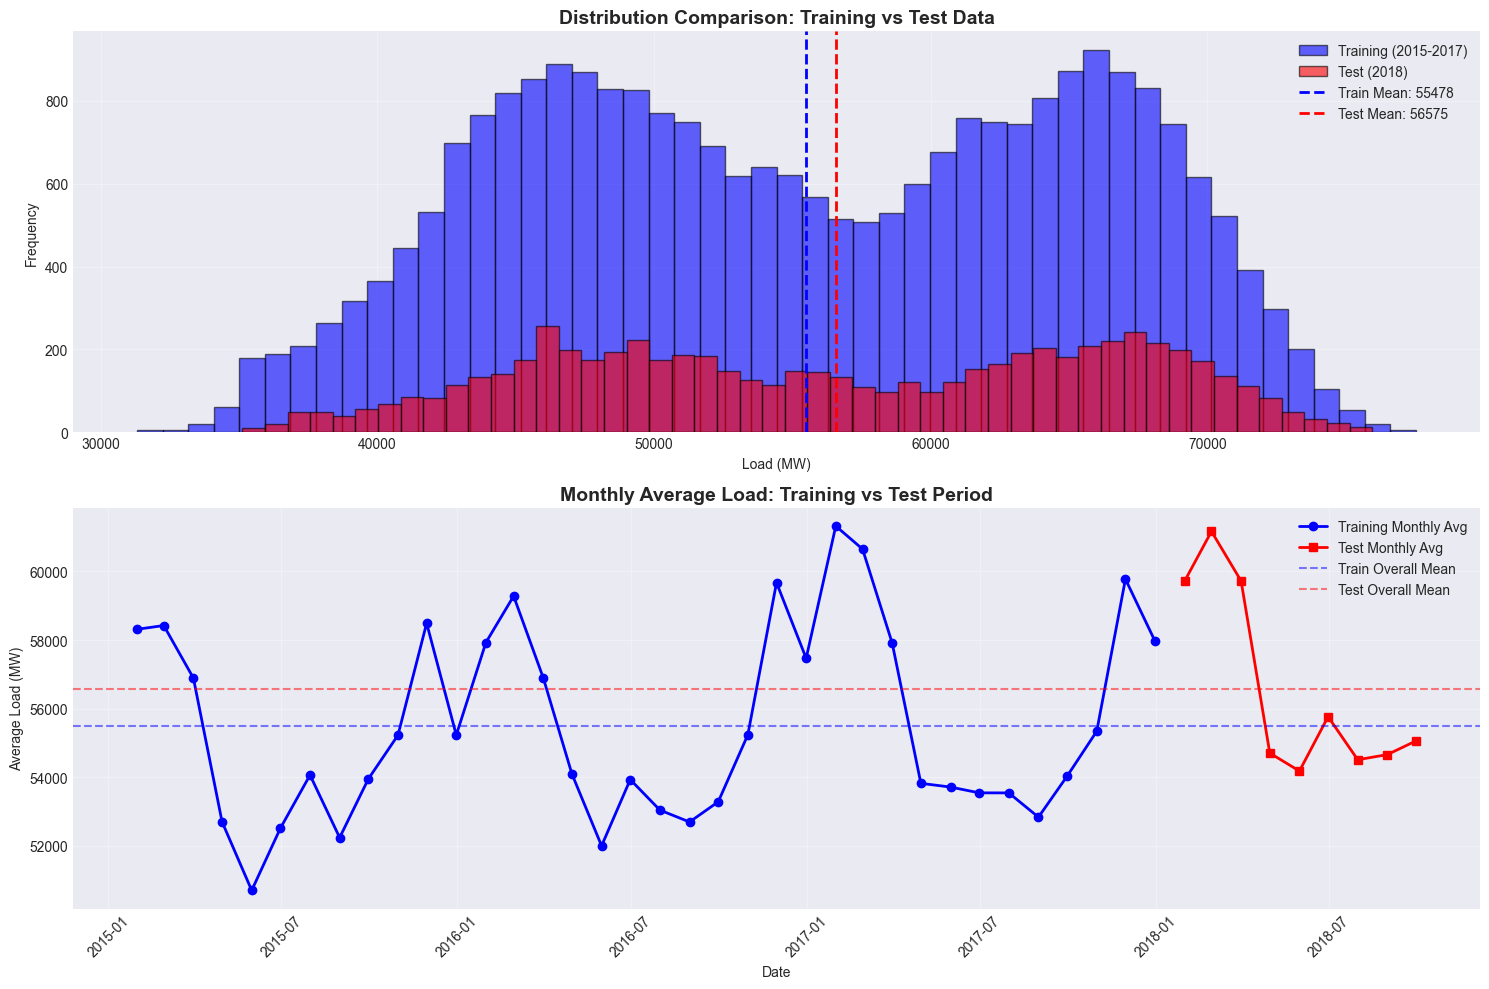

In [19]:

# Split data: 2015-2017 for training, 2018 for testing
train_end = '2017-12-31 23:00:00'
test_start = '2018-01-01 00:00:00'

train_data = ts[:train_end].copy()
test_data = ts[test_start:].copy()

# Preserve frequency information to avoid warnings
if ts.index.freq is not None:
    train_data.index.freq = ts.index.freq
    test_data.index.freq = ts.index.freq

print(f"Training samples: {len(train_data):,}")
print(f"Test samples: {len(test_data):,}")

# Check for distribution shift between train and test
train_stats = train_data.describe()
test_stats = test_data.describe()

mean_shift = test_stats['mean'] - train_stats['mean']
std_shift = test_stats['std'] - train_stats['std']
mean_shift_pct = (mean_shift / train_stats['mean']) * 100

print(f"Mean shift: {mean_shift:.2f} MW ({mean_shift_pct:.2f}%)")

# Visualize distribution shift
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Overlay distributions
axes[0].hist(train_data.values, bins=50, alpha=0.6, label='Training (2015-2017)', color='blue', edgecolor='black')
axes[0].hist(test_data.values, bins=50, alpha=0.6, label='Test (2018)', color='red', edgecolor='black')
axes[0].axvline(train_stats['mean'], color='blue', linestyle='--', linewidth=2, label=f'Train Mean: {train_stats["mean"]:.0f}')
axes[0].axvline(test_stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Test Mean: {test_stats["mean"]:.0f}')
axes[0].set_title('Distribution Comparison: Training vs Test Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Load (MW)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Monthly averages comparison
train_monthly = train_data.resample('M').mean()
test_monthly = test_data.resample('M').mean()

axes[1].plot(train_monthly.index, train_monthly.values, marker='o', label='Training Monthly Avg', linewidth=2, color='blue')
axes[1].plot(test_monthly.index, test_monthly.values, marker='s', label='Test Monthly Avg', linewidth=2, color='red')
axes[1].axhline(train_stats['mean'], color='blue', linestyle='--', alpha=0.5, label=f'Train Overall Mean')
axes[1].axhline(test_stats['mean'], color='red', linestyle='--', alpha=0.5, label=f'Test Overall Mean')
axes[1].set_title('Monthly Average Load: Training vs Test Period', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Average Load (MW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

plt.savefig('../../saved_model_outputs/sarima_outputs/00_data_shift_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Decision: If significant shift, use more recent training data
if abs(mean_shift_pct) > 5:
    train_data_adjusted = train_data[-24*30*18:].copy()
    train_data = train_data_adjusted


## Step 4: Exploratory Data Analysis


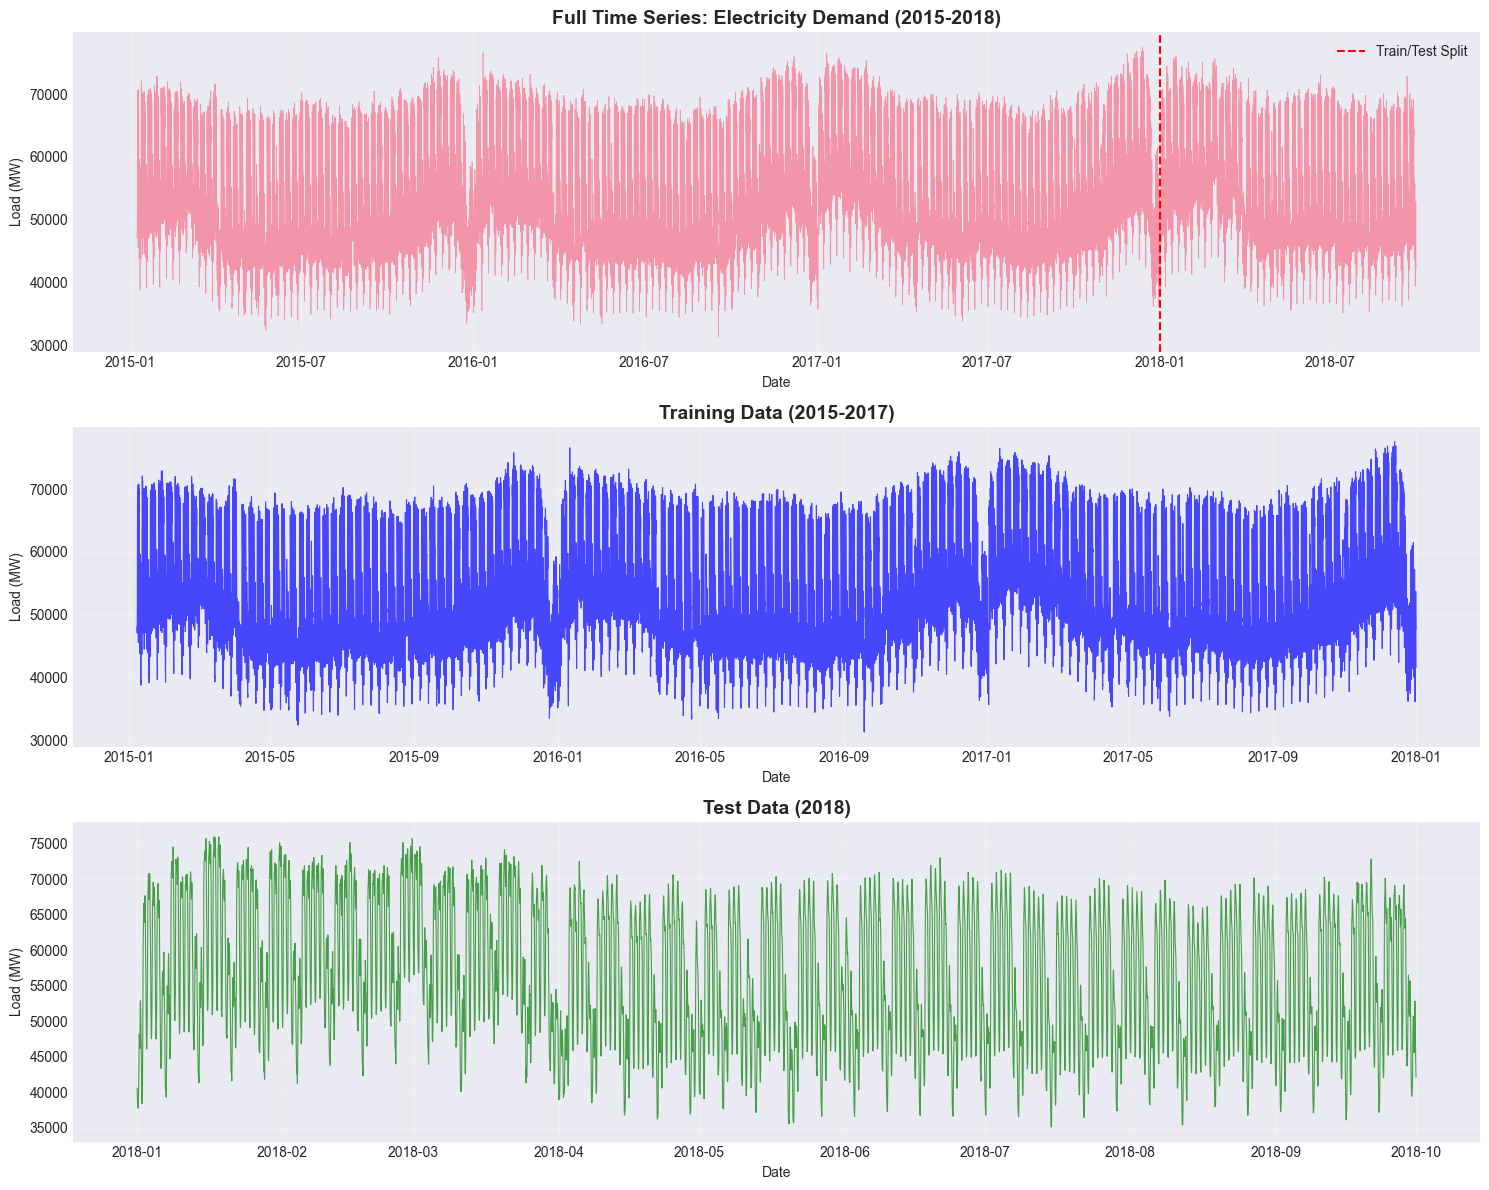

In [20]:
# Plot full time series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Full series
axes[0].plot(ts.index, ts.values, linewidth=0.5, alpha=0.7)
axes[0].axvline(x=pd.Timestamp(train_end), color='r', linestyle='--', label='Train/Test Split')
axes[0].set_title('Full Time Series: Electricity Demand (2015-2018)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training data
axes[1].plot(train_data.index, train_data.values, linewidth=0.8, color='blue', alpha=0.7)
axes[1].set_title('Training Data (2015-2017)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].grid(True, alpha=0.3)

# Test data
axes[2].plot(test_data.index, test_data.values, linewidth=0.8, color='green', alpha=0.7)
axes[2].set_title('Test Data (2018)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Load (MW)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/01_time_series_overview.png', dpi=300, bbox_inches='tight')
plt.show()


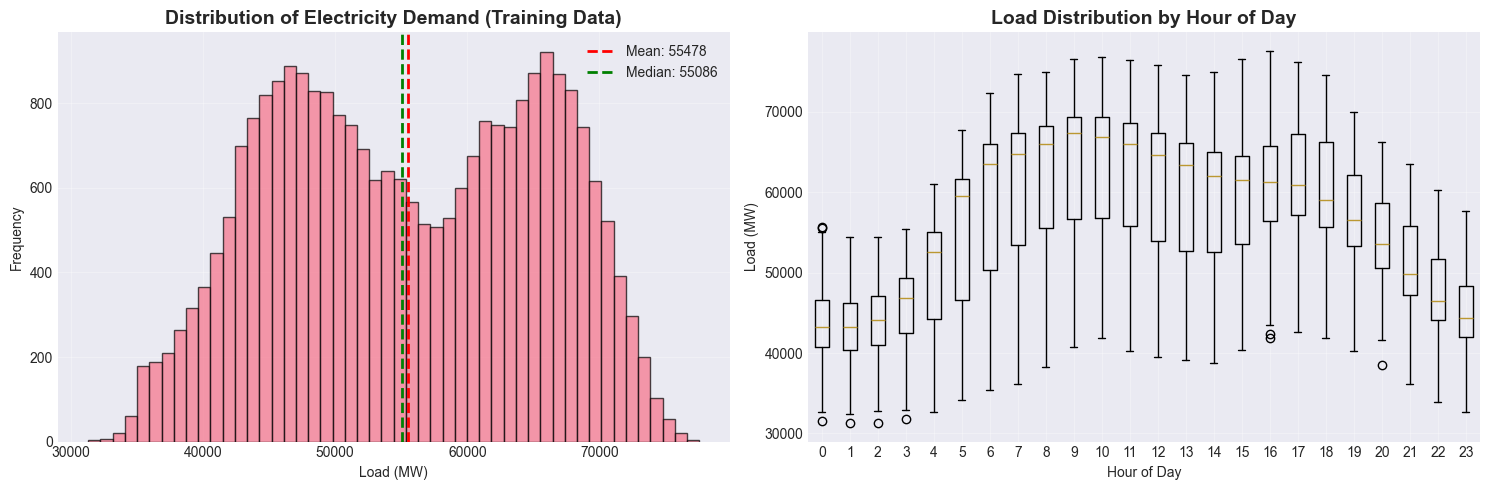

In [21]:
# Distribution and boxplot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train_data.values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(train_data.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {train_data.mean():.0f}')
axes[0].axvline(train_data.median(), color='g', linestyle='--', linewidth=2, label=f'Median: {train_data.median():.0f}')
axes[0].set_title('Distribution of Electricity Demand (Training Data)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Load (MW)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot by hour
train_data_hour = pd.DataFrame({target_col: train_data.values}, index=train_data.index)
train_data_hour['hour'] = train_data_hour.index.hour
hourly_data = [train_data_hour[train_data_hour['hour'] == h][target_col].values for h in range(24)]
axes[1].boxplot(hourly_data, labels=range(24))
axes[1].set_title('Load Distribution by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Load (MW)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/03_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 5: Seasonality Analysis


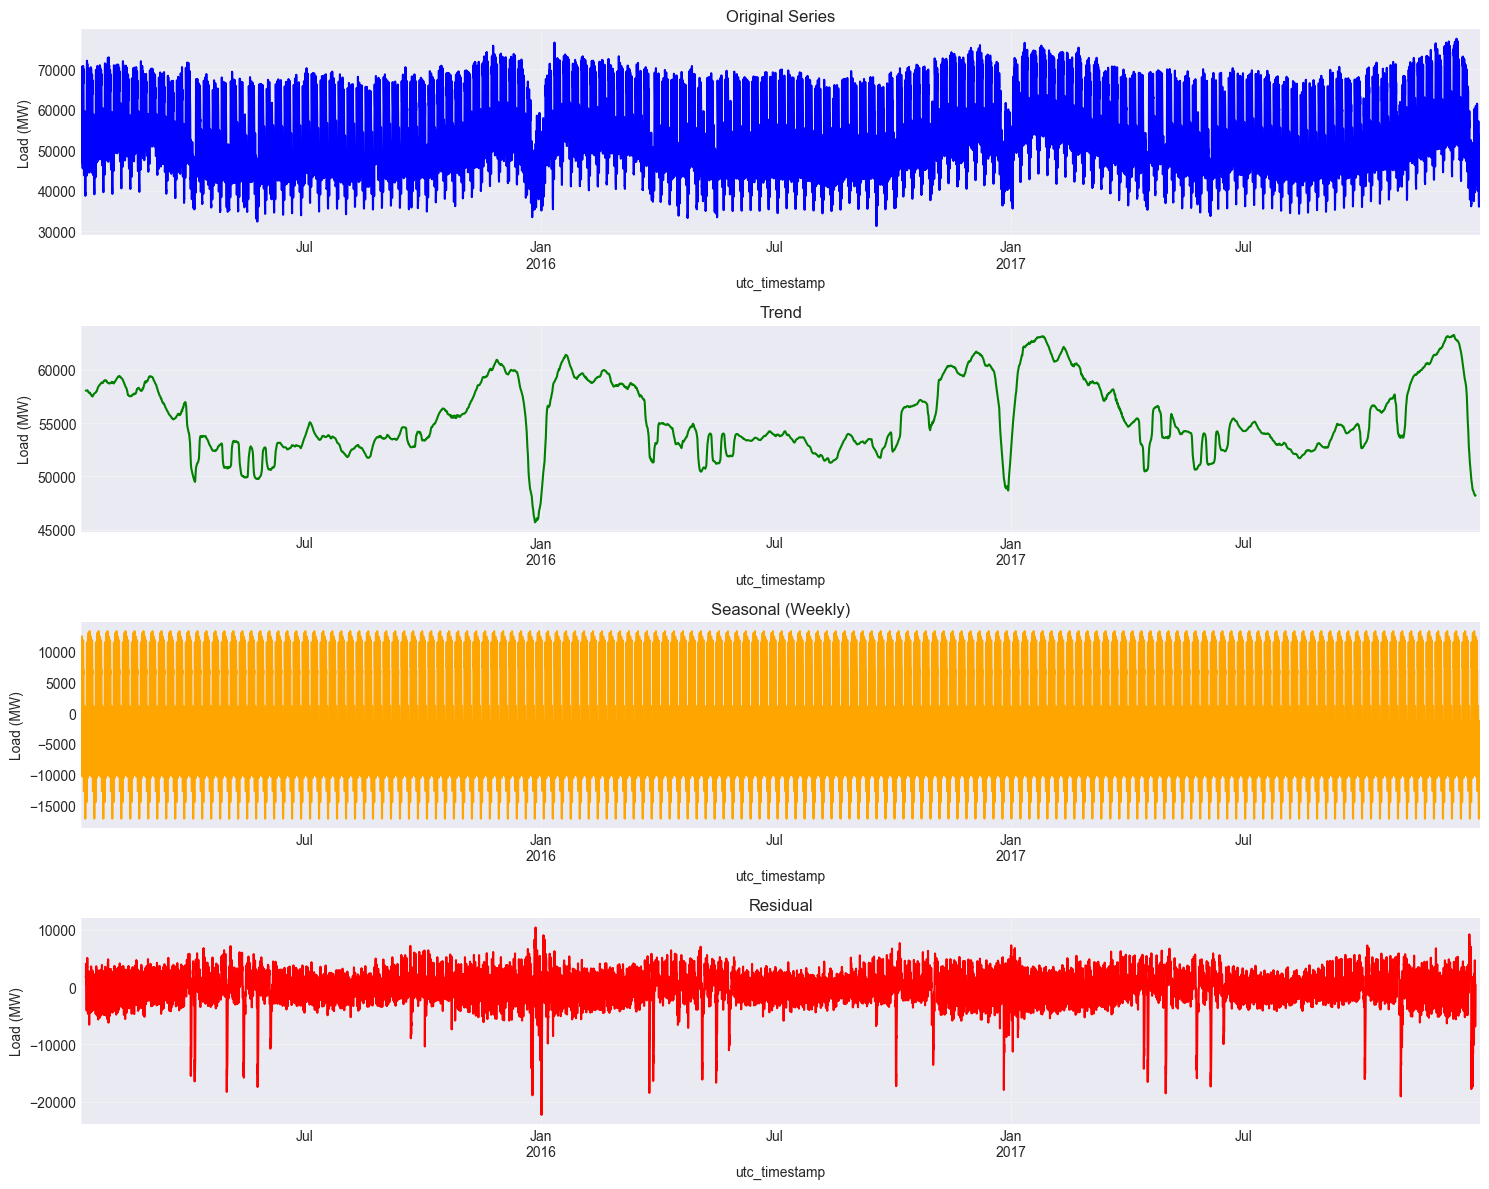

Peak hour: 10 (63877 MW)
Peak day: Wed (59596 MW)


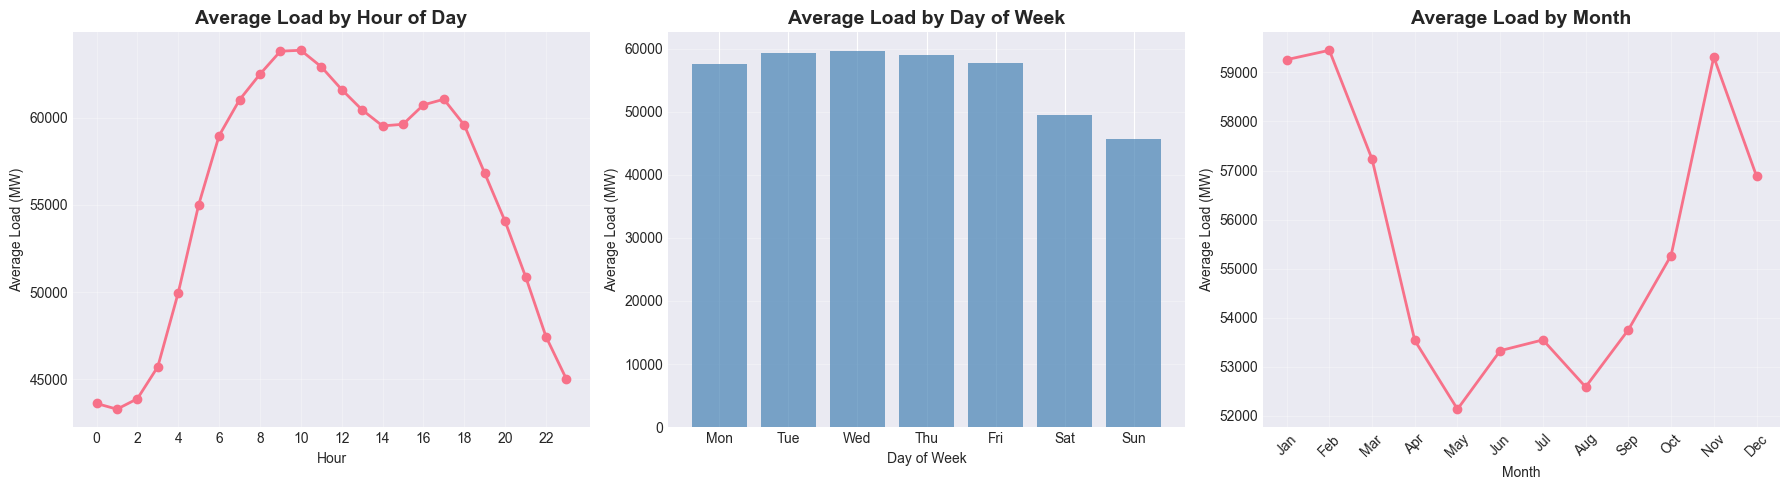

In [23]:
# Seasonal decomposition
decomposition = seasonal_decompose(train_data, model='additive', period=24*7)  # Weekly seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='Original Series', color='blue')
decomposition.trend.plot(ax=axes[1], title='Trend', color='green')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal (Weekly)', color='orange')
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')

for ax in axes:
    ax.set_ylabel('Load (MW)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/04_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate average patterns
train_data_copy = pd.DataFrame({target_col: train_data.values}, index=train_data.index)
train_data_copy['hour'] = train_data_copy.index.hour
train_data_copy['day_of_week'] = train_data_copy.index.day_of_week
train_data_copy['month'] = train_data_copy.index.month

avg_by_hour = train_data_copy.groupby('hour')[target_col].mean()
avg_by_dow = train_data_copy.groupby('day_of_week')[target_col].mean()
avg_by_month = train_data_copy.groupby('month')[target_col].mean()

print(f"Peak hour: {avg_by_hour.idxmax()} ({avg_by_hour.max():.0f} MW)")
print(f"Peak day: {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][avg_by_dow.idxmax()]} ({avg_by_dow.max():.0f} MW)")

# Plot seasonal patterns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(avg_by_hour.index, avg_by_hour.values, marker='o', linewidth=2, markersize=6)
axes[0].set_title('Average Load by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Average Load (MW)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))

dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1].bar(range(7), avg_by_dow.values, color='steelblue', alpha=0.7)
axes[1].set_title('Average Load by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Load (MW)')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(dow_labels)
axes[1].grid(True, alpha=0.3, axis='y')

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[2].plot(avg_by_month.index, avg_by_month.values, marker='o', linewidth=2, markersize=6)
axes[2].set_title('Average Load by Month', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Average Load (MW)')
axes[2].set_xticks(range(1, 13))
axes[2].set_xticklabels(month_labels, rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/05_seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 6: Stationarity Tests


In [24]:
def adf_test(timeseries):
    """Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'ADF p-value: {result[1]:.4f}')
    return result[1] <= 0.05

def kpss_test(timeseries):
    """KPSS test for stationarity"""
    result = kpss(timeseries.dropna(), regression='c', nlags='auto')
    print(f'KPSS p-value: {result[1]:.4f}')
    return result[1] >= 0.05

print("Original series:")
adf_stationary = adf_test(train_data)
kpss_stationary = kpss_test(train_data)


Original series:
ADF p-value: 0.0000
KPSS p-value: 0.0305



First difference:
ADF p-value: 0.0000
KPSS p-value: 0.1000


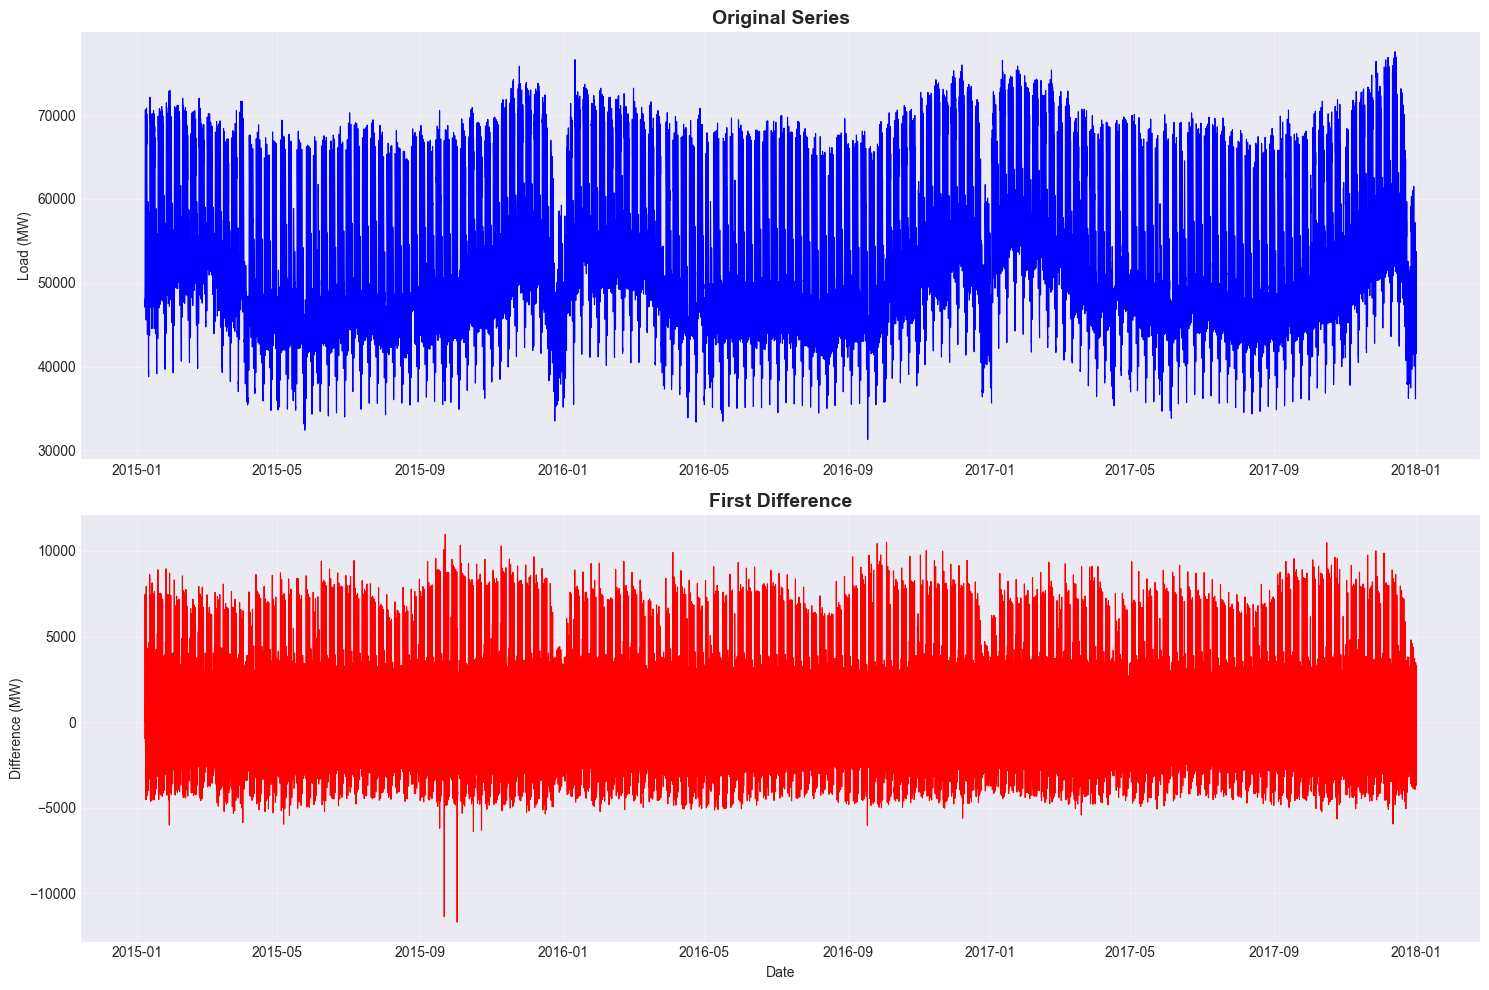

In [25]:
# Test first difference
train_diff1 = train_data.diff().dropna()

print("\nFirst difference:")
adf_stationary_diff1 = adf_test(train_diff1)
kpss_stationary_diff1 = kpss_test(train_diff1)

# Plot original vs differenced
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].plot(train_data.index, train_data.values, linewidth=0.8, color='blue')
axes[0].set_title('Original Series', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Load (MW)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(train_diff1.index, train_diff1.values, linewidth=0.8, color='red')
axes[1].set_title('First Difference', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Difference (MW)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/06_differencing.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 7: ACF and PACF Analysis


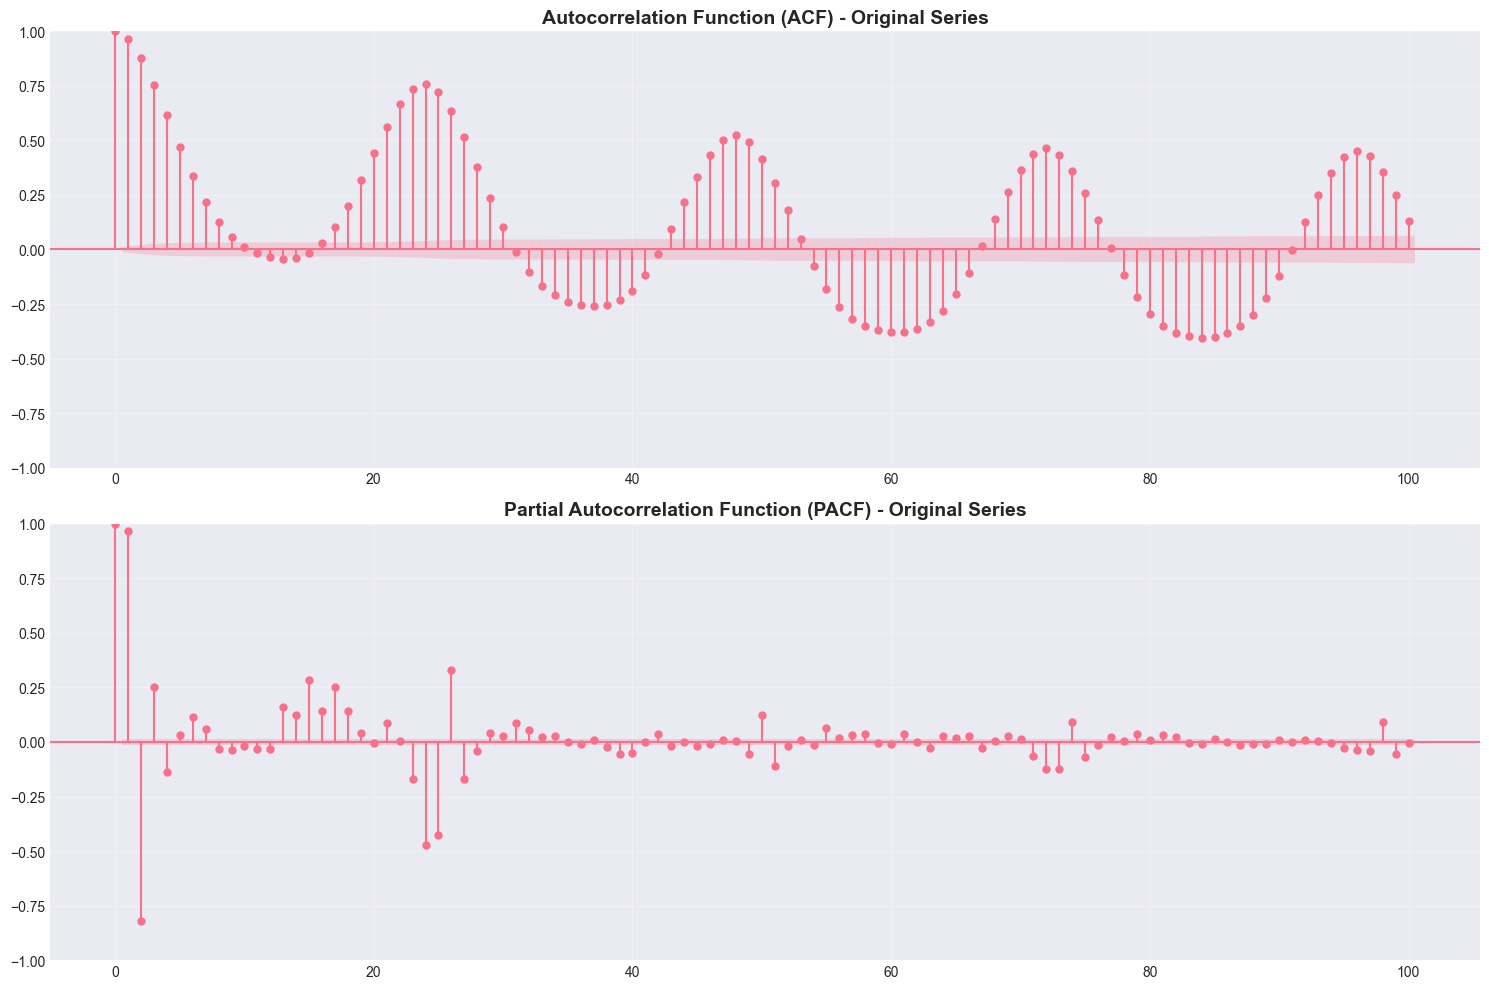

In [27]:
# Plot ACF and PACF for original series
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

plot_acf(train_data, lags=100, ax=axes[0], alpha=0.05)
axes[0].set_title('Autocorrelation Function (ACF) - Original Series', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

plot_pacf(train_data, lags=100, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF) - Original Series', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/07_acf_pacf_original.png', dpi=300, bbox_inches='tight')
plt.show()


 ============================================================================
 QUICK DEFAULT MODEL OPTION (Use this if Cell 18 is taking too long!)
 ============================================================================
 Uncomment and run this cell to skip grid search and use a reasonable default
 This will complete instantly instead of taking hours!

 seasonal_period = 24 * 7  # 168 hours = 1 week
 best_order = (1, 1, 1)  # Common choice for electricity demand
 best_seasonal_order = (1, 1, 1, seasonal_period)  # Seasonal ARIMA(1,1,1)
 print(f"Using default model: SARIMA{best_order}x{best_seasonal_order}")
 print("This is a reasonable default for hourly electricity demand forecasting.")
 print("You can now skip Cell 18 and go directly to Cell 20!")


In [ ]:
# ============================================================================
# DEFAULT MODEL (FEW MODELS) - COMMENTED OUT
# ============================================================================
# This uses a single default model (SARIMA(1,1,1)x(1,1,1,168))
# This is the "few models" approach - now commented out in favor of full grid search
# Uncomment this if you want to skip grid search and use a quick default model

# seasonal_period = 24 * 7  # 168 hours = 1 week
# best_order = (1, 1, 1)  # Common choice for electricity demand
# best_seasonal_order = (1, 1, 1, seasonal_period)  # Seasonal ARIMA(1,1,1)
# print(f"Using default model: SARIMA{best_order}x{best_seasonal_order}")
# print("This is a reasonable default for hourly electricity demand forecasting.")
# print("You can now skip Cell 18 and go directly to Cell 20!")

In [28]:
# Use daily seasonality (24 hours)
seasonal_period = 24
train_data_reduced = train_data[-24*30*12:].copy()

best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, seasonal_period)

final_model = ARIMA(
    train_data_reduced,
    order=best_order,
    seasonal_order=best_seasonal_order
).fit(low_memory=True)

print(final_model.summary())


                                    SARIMAX Results                                     
Dep. Variable:                      target_load   No. Observations:                 8640
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -70214.343
Date:                          Mon, 12 Jan 2026   AIC                         140438.686
Time:                                  22:07:27   BIC                         140473.993
Sample:                              01-06-2017   HQIC                        140450.726
                                   - 12-31-2017                                         
Covariance Type:                         approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4005      0.013     30.380      0.000       0.375       0.426
ma.L1          0.3520      0.013     28.093      0.

In [ ]:
# # ============================================================================
# # FAST MODEL FITTING - USE THIS INSTEAD OF CELL 20 IF IT'S TOO SLOW!
# # ============================================================================
# # This uses a smaller dataset and faster method to complete in MINUTES, not hours

# print("="*80)
# print("FAST MODEL FITTING (Using last 6 months of training data)")
# print("="*80)

# # Use only last 6 months of training data for faster fitting
# train_data_fast = train_data[-24*30*6:].copy()  # Last 6 months (~4320 hours)
# print(f"Using {len(train_data_fast):,} samples (last 6 months) instead of {len(train_data):,} for speed")

# # Use simpler model: SARIMA(1,1,1)x(1,1,1,24) - daily seasonality instead of weekly
# # This is MUCH faster than weekly seasonality (168)
# seasonal_period_fast = 24  # Daily seasonality (24 hours)
# best_order_fast = (1, 1, 1)
# best_seasonal_order_fast = (1, 1, 1, seasonal_period_fast)

# print(f"\nFitting: SARIMA{best_order_fast}x{best_seasonal_order_fast}")
# print("Using fast CSS-ML method with limited iterations...")

# # Fit with fast method
# final_model = ARIMA(
#     train_data_fast,
#     order=best_order_fast,
#     seasonal_order=best_seasonal_order_fast
# ).fit(method='css-ml', maxiter=30, disp=0)

# # Update best_order variables for compatibility with later cells
# best_order = best_order_fast
# best_seasonal_order = best_seasonal_order_fast

# print("\n" + "="*80)
# print("MODEL FITTED SUCCESSFULLY!")
# print("="*80)
# print(final_model.summary())


## Step 8: Model Selection


In [ ]:
# ============================================================================
# FULL GRID SEARCH (ALL POSSIBLE MODELS) - COMMENTED OUT
# ============================================================================
# This cell is COMMENTED OUT because it causes MemoryError with weekly seasonality
# Use Cell 20 instead, which uses reduced data and manual SARIMA model
# This avoids memory issues while still using weekly seasonality (168h)

# # Determine seasonal period (24 hours * 7 days = 168 for weekly seasonality)
# seasonal_period = 24 * 7  # 168 hours = 1 week
# print(f"Seasonal period: {seasonal_period} hours (1 week)")

# auto_model = None
# use_auto_arima = AUTO_ARIMA_AVAILABLE

# if use_auto_arima:
#     print("\nUsing FAST pmdarima auto_arima for model selection...")
#     print("Using optimized settings for speed (will complete in minutes, not hours)...")
    
#     try:
#         # FAST VERSION: Reduced parameter space and aggressive stepwise search
#         # This will complete much faster while still finding a good model
#         auto_model = auto_arima(
#             train_data,
#             start_p=0, start_q=0,
#             max_p=2, max_q=2,  # Reduced from 3 to 2 for speed
#             start_P=0, start_Q=0,
#             max_P=1, max_Q=1,  # Reduced from 2 to 1 for speed
#             m=seasonal_period,  # Weekly seasonality
#             seasonal=True,
#             d=1,  # First difference
#             D=1,  # Seasonal difference
#             trace=True,
#             error_action='ignore',
#             suppress_warnings=True,
#             stepwise=True,  # Stepwise search
#             n_jobs=1,
#             max_iter=10,  # Limit iterations for speed
#             information_criterion='aic',  # Use AIC
#             with_intercept=True,
#             random_state=42  # For reproducibility
#         )
        
#         print("\n" + "="*80)
#         print("BEST MODEL SELECTED BY auto_arima (stepwise search)")
#         print("="*80)
#         print(auto_model.summary())
        
#         # Extract best parameters
#         best_order = auto_model.order
#         best_seasonal_order = auto_model.seasonal_order
        
#         print(f"\nBest order (p, d, q): {best_order}")
#         print(f"Best seasonal order (P, D, Q, s): {best_seasonal_order}")
        
#     except (MemoryError, Exception) as e:
#         print(f"\nError in auto_arima: {type(e).__name__}: {e}")
#         print("Falling back to sequential manual grid search...")
#         auto_model = None
#         use_auto_arima = False

# if not use_auto_arima or auto_model is None:
#     print("\nUsing FAST sequential manual grid search for model selection...")
#     print("Using reduced parameter space for speed (will complete in minutes)...")
    
#     # FAST Grid search parameters - reduced for speed
#     p_values = [0, 1, 2]  # Reduced from range(0, 4)
#     d_values = [1]  # Based on stationarity tests
#     q_values = [0, 1, 2]  # Reduced from range(0, 4)
#     P_values = [0, 1]  # Reduced from range(0, 3)
#     D_values = [1]  # Seasonal differencing
#     Q_values = [0, 1]  # Reduced from range(0, 3)
    
#     total_models = len(p_values) * len(d_values) * len(q_values) * len(P_values) * len(D_values) * len(Q_values)
#     print(f"Testing {total_models} model combinations (reduced for speed)...")
    
#     # Manual grid search - sequential to avoid memory issues
#     best_aic = np.inf
#     best_order = None
#     best_seasonal_order = None
    
#     results = []
#     import time
#     start_time = time.time()
    
#     model_count = 0
#     for p in p_values:
#         for d in d_values:
#             for q in q_values:
#                 for P in P_values:
#                     for D in D_values:
#                         for Q in Q_values:
#                             model_count += 1
#                             try:
#                                 model = ARIMA(
#                                     train_data,
#                                     order=(p, d, q),
#                                     seasonal_order=(P, D, Q, seasonal_period)
#                                 )
#                                 fitted_model = model.fit()
#                                 aic = fitted_model.aic
                                
#                                 results.append({
#                                     'order': (p, d, q),
#                                     'seasonal_order': (P, D, Q, seasonal_period),
#                                     'aic': aic
#                                 })
                                
#                                 if aic < best_aic:
#                                     best_aic = aic
#                                     best_order = (p, d, q)
#                                     best_seasonal_order = (P, D, Q, seasonal_period)
                                
#                                 # Progress update every 10 models
#                                 if model_count % 10 == 0:
#                                     elapsed = time.time() - start_time
#                                     print(f"Progress: {model_count}/{total_models} models tested (Best AIC so far: {best_aic:.2f}, Elapsed: {elapsed/60:.1f} min)")
                                
#                             except Exception as e:
#                                 continue
    
#     elapsed_time = time.time() - start_time
#     print(f"\nGrid search completed in {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
    
#     # Filter successful results
#     successful_results = results
#     print(f"Successfully fitted {len(successful_results)} out of {total_models} models")
    
#     # Find best model
#     if successful_results:
#         # Create results dataframe for display
#         results_df = pd.DataFrame(successful_results)
        
#         print("\n" + "="*80)
#         print("BEST MODEL FROM GRID SEARCH")
#         print("="*80)
#         print(f"Best order (p, d, q): {best_order}")
#         print(f"Best seasonal order (P, D, Q, s): {best_seasonal_order}")
#         print(f"Best AIC: {best_aic:.2f}")
        
#         # Show top 5 models
#         results_df_sorted = results_df.sort_values('aic').head(5)
#         print("\nTop 5 models by AIC:")
#         print(results_df_sorted.to_string(index=False))
#     else:
#         raise ValueError("No models were successfully fitted!")

# Grid search commented out - using manual model from Cell 20


CELL 23 COMMENTED OUT - Use Cell 20 instead
This cell causes MemoryError with weekly seasonality on full dataset.
Cell 20 uses reduced data (last 1.5 years) and manual SARIMA(1,1,1)x(1,1,1,168)
which avoids memory issues while maintaining weekly seasonality.


In [29]:
# Model should already be fitted in Cell 20
try:
    if 'final_model' not in locals() or final_model is None:
        seasonal_period = 24
        best_order = (1, 1, 1)
        best_seasonal_order = (1, 1, 1, seasonal_period)
        train_data_reduced = train_data[-24*30*12:].copy()
        final_model = ARIMA(
            train_data_reduced,
            order=best_order,
            seasonal_order=best_seasonal_order
        ).fit(low_memory=True)
except NameError:
    seasonal_period = 24
    best_order = (1, 1, 1)
    best_seasonal_order = (1, 1, 1, seasonal_period)
    train_data_reduced = train_data[-24*30*12:].copy()
    final_model = ARIMA(
        train_data_reduced,
        order=best_order,
        seasonal_order=best_seasonal_order
    ).fit(low_memory=True)

print(final_model.summary())


                                    SARIMAX Results                                     
Dep. Variable:                      target_load   No. Observations:                 8640
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -70214.343
Date:                          Mon, 12 Jan 2026   AIC                         140438.686
Time:                                  22:07:27   BIC                         140473.993
Sample:                              01-06-2017   HQIC                        140450.726
                                   - 12-31-2017                                         
Covariance Type:                         approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4005      0.013     30.380      0.000       0.375       0.426
ma.L1          0.3520      0.013     28.093      0.

## Step 10: Model Diagnostics


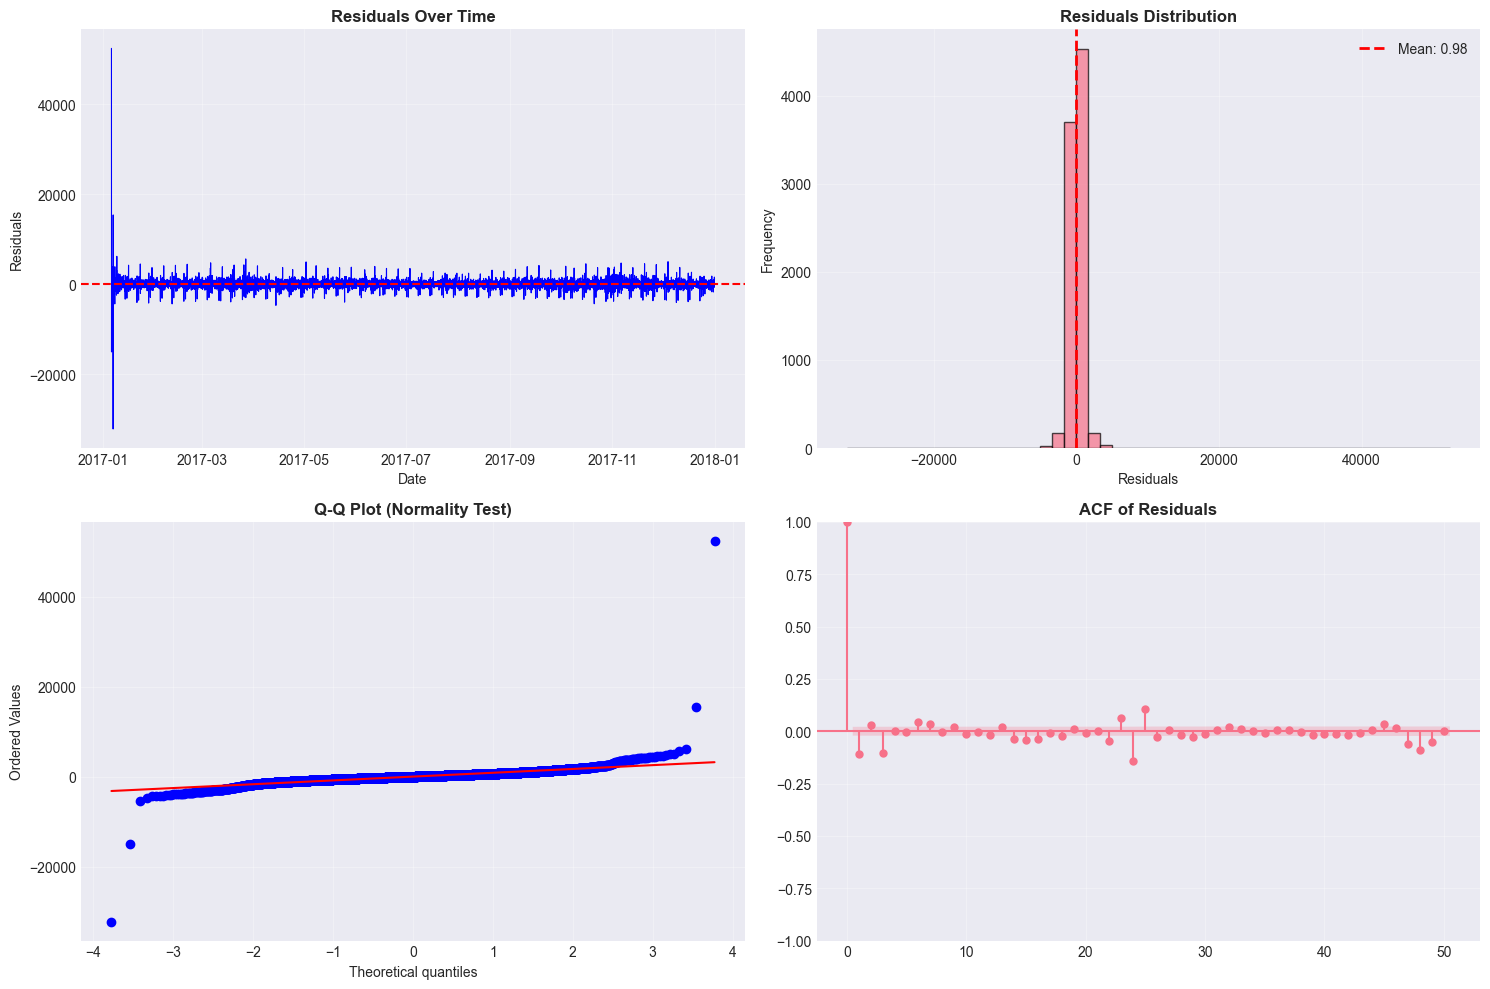

Mean: 0.9806
Std: 1087.9917
Skewness: 9.9364
Kurtosis: 720.0486


In [31]:
# Residual analysis
residuals = final_model.resid

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Residuals time series
axes[0, 0].plot(residuals.index, residuals.values, linewidth=0.8, color='blue')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Residuals distribution
axes[0, 1].hist(residuals.values, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(residuals.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {residuals.mean():.2f}')
axes[0, 1].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals.values, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=50, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('ACF of Residuals', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/09_residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Residual statistics
print(f"Mean: {residuals.mean():.4f}")
print(f"Std: {residuals.std():.4f}")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")


In [32]:
# Ljung-Box test for residual autocorrelation
ljung_box = acorr_ljungbox(residuals, lags=20, return_df=True)
print(ljung_box.head(10))

p_values = ljung_box['lb_pvalue'].values
if all(p > 0.05 for p in p_values):
    print("No significant autocorrelation")
else:
    print(f"Significant autocorrelation at {sum(p <= 0.05 for p in p_values)} lags")


       lb_stat     lb_pvalue
1   105.010261  1.215050e-24
2   112.268145  4.181018e-25
3   201.661095  1.846029e-43
4   201.741802  1.586260e-42
5   201.832983  1.151518e-41
6   218.544547  2.126146e-44
7   229.320172  6.921510e-46
8   229.583239  3.627530e-45
9   232.687642  4.468135e-45
10  234.182039  1.139886e-44
Significant autocorrelation at 20 lags


## Step 11: Forecasting


In [33]:
# Generate forecasts for test period
forecast_steps = len(test_data)
forecast_result = final_model.get_forecast(steps=forecast_steps)
forecast = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# Align forecast index with test data
forecast.index = test_data.index
forecast_ci.index = test_data.index

print(f"Forecast mean: {forecast.mean():.2f} MW")
print(f"Actual mean: {test_data.mean():.2f} MW")


Forecast mean: 45527.81 MW
Actual mean: 56575.33 MW


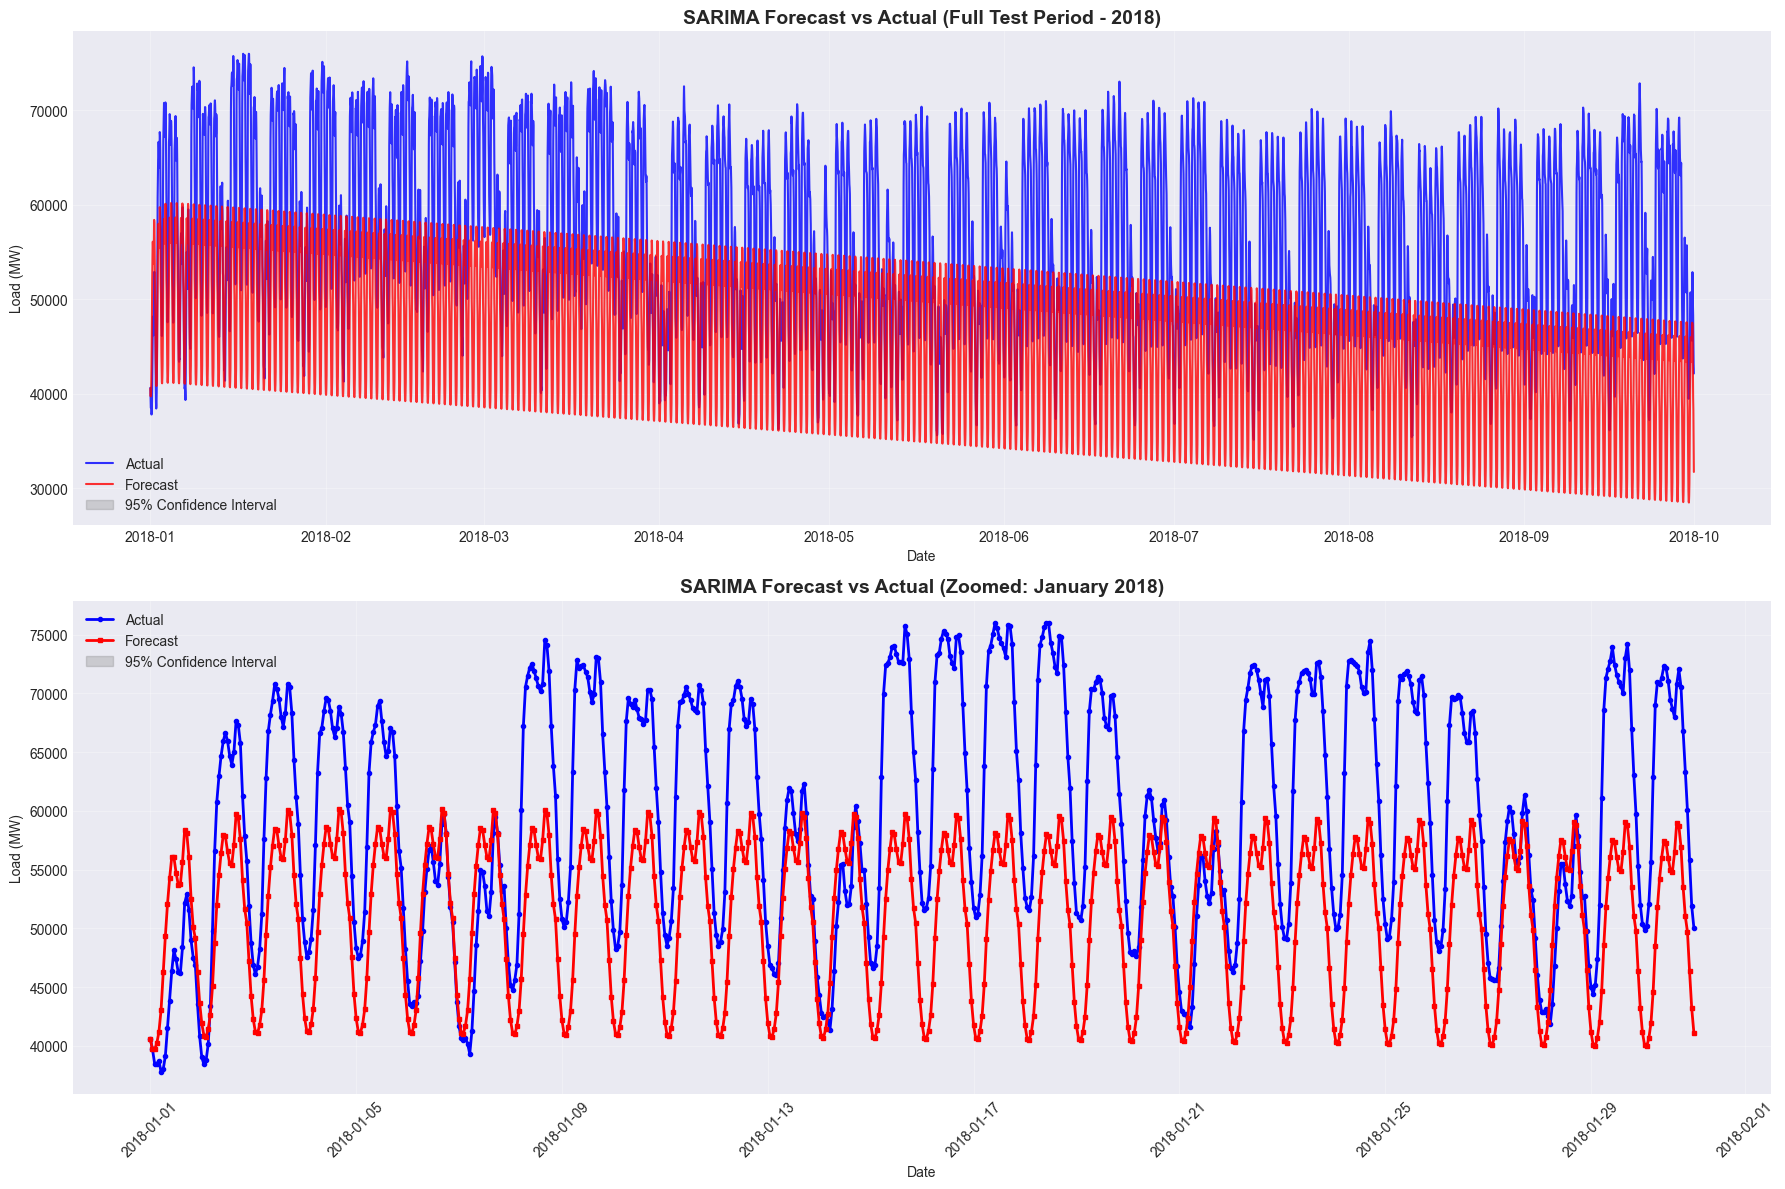

In [34]:
# Plot forecasts vs actuals
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Full forecast period
axes[0].plot(test_data.index, test_data.values, label='Actual', linewidth=1.5, color='blue', alpha=0.8)
axes[0].plot(forecast.index, forecast.values, label='Forecast', linewidth=1.5, color='red', alpha=0.8)
axes[0].fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], 
                     alpha=0.3, color='gray', label='95% Confidence Interval')
axes[0].set_title('SARIMA Forecast vs Actual (Full Test Period - 2018)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Load (MW)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Zoomed view (one month)
zoom_start = '2018-01-01'
zoom_end = '2018-01-31'
zoom_mask = (test_data.index >= zoom_start) & (test_data.index <= zoom_end)
test_zoom = test_data[zoom_mask]
forecast_zoom = forecast[zoom_mask]
forecast_ci_zoom = forecast_ci[zoom_mask]

axes[1].plot(test_zoom.index, test_zoom.values, label='Actual', linewidth=2, marker='o', markersize=3, color='blue')
axes[1].plot(forecast_zoom.index, forecast_zoom.values, label='Forecast', linewidth=2, marker='s', markersize=3, color='red')
axes[1].fill_between(forecast_ci_zoom.index, forecast_ci_zoom.iloc[:, 0], forecast_ci_zoom.iloc[:, 1], 
                     alpha=0.3, color='gray', label='95% Confidence Interval')
axes[1].set_title('SARIMA Forecast vs Actual (Zoomed: January 2018)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Load (MW)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/10_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()


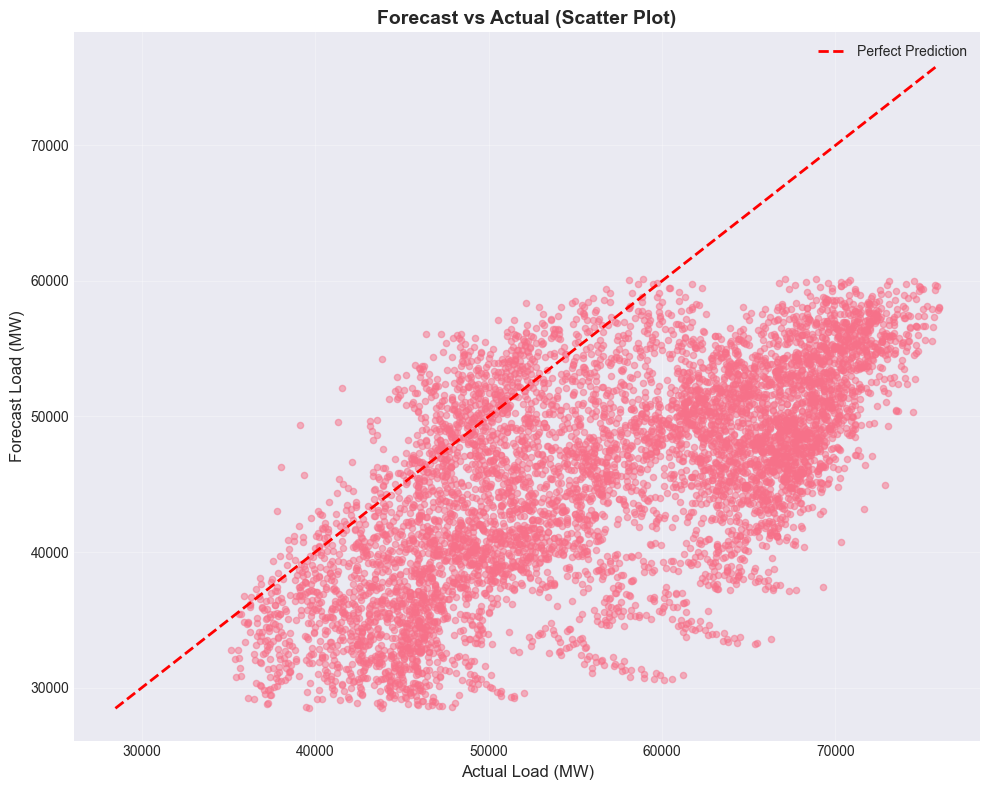

In [35]:
# Scatter plot: Forecast vs Actual
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(test_data.values, forecast.values, alpha=0.5, s=20)

# Perfect prediction line
min_val = min(test_data.min(), forecast.min())
max_val = max(test_data.max(), forecast.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('Actual Load (MW)', fontsize=12)
ax.set_ylabel('Forecast Load (MW)', fontsize=12)
ax.set_title('Forecast vs Actual (Scatter Plot)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/11_forecast_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 12: Performance Metrics


In [36]:
# Calculate performance metrics
def calculate_metrics(actual, forecast):
    """Calculate comprehensive performance metrics"""
    # Remove any NaN values
    mask = ~(np.isnan(actual) | np.isnan(forecast))
    actual_clean = actual[mask]
    forecast_clean = forecast[mask]
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(actual_clean - forecast_clean))
    
    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(np.mean((actual_clean - forecast_clean)**2))
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_clean - forecast_clean) / actual_clean)) * 100
    
    # Mean Error (Bias)
    me = np.mean(forecast_clean - actual_clean)
    
    # Mean Absolute Scaled Error (MASE) - using naive forecast as baseline
    naive_forecast = actual_clean.shift(1).dropna()
    naive_error = np.mean(np.abs(actual_clean[1:] - naive_forecast))
    mase = mae / naive_error if naive_error > 0 else np.nan
    
    # R-squared
    ss_res = np.sum((actual_clean - forecast_clean)**2)
    ss_tot = np.sum((actual_clean - np.mean(actual_clean))**2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    
    # Directional Accuracy
    actual_diff = np.diff(actual_clean)
    forecast_diff = np.diff(forecast_clean)
    directional_accuracy = np.mean((actual_diff * forecast_diff) > 0) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'ME': me,
        'MASE': mase,
        'R2': r2,
        'Directional Accuracy': directional_accuracy
    }

# Calculate metrics
metrics = calculate_metrics(test_data, forecast)

print(f"MAE: {metrics['MAE']:.2f} MW")
print(f"RMSE: {metrics['RMSE']:.2f} MW")
print(f"MAPE: {metrics['MAPE']:.2f}%")
print(f"R²: {metrics['R2']:.4f}")

errors = test_data - forecast
print(f"Mean Error: {errors.mean():.2f} MW")
print(f"Std Error: {errors.std():.2f} MW")


MAE: 11509.05 MW
RMSE: 13345.42 MW
MAPE: 19.55%
R²: -0.8410
Mean Error: 11047.51 MW
Std Error: 7487.40 MW


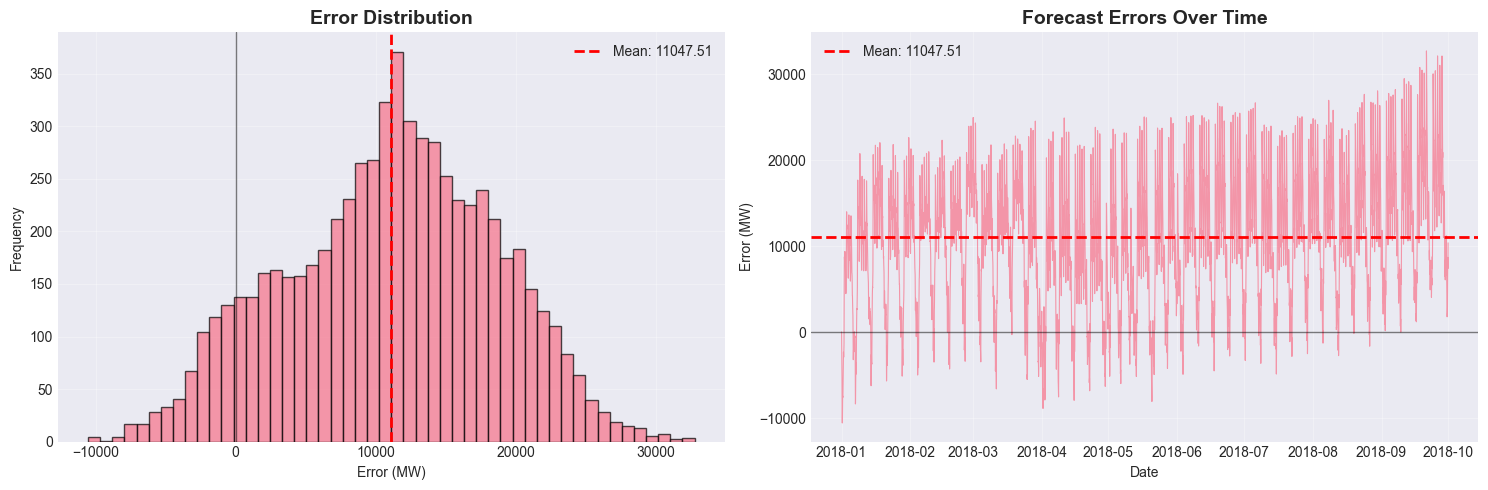

In [37]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Error histogram
axes[0].hist(errors.values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(errors.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[0].axvline(0, color='k', linestyle='-', linewidth=1, alpha=0.5)
axes[0].set_title('Error Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Error (MW)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Error over time
axes[1].plot(errors.index, errors.values, linewidth=0.8, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.5)
axes[1].axhline(y=errors.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {errors.mean():.2f}')
axes[1].set_title('Forecast Errors Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Error (MW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../saved_model_outputs/sarima_outputs/12_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## Step 13: Save Results


In [38]:
# Create forecasts dataframe
results_df = pd.DataFrame({
    'actual': test_data.values,
    'forecast': forecast.values,
    'error': errors.values,
    'lower_ci': forecast_ci.iloc[:, 0].values,
    'upper_ci': forecast_ci.iloc[:, 1].values
}, index=test_data.index)

# Save to CSV
results_df.to_csv('../../saved_model_outputs/sarima_outputs/sarima_forecasts.csv')

# Save metrics to JSON
import json
metrics_dict = {k: float(v) if not np.isnan(v) else None for k, v in metrics.items()}

if 'best_order' in locals() and 'best_seasonal_order' in locals():
    metrics_dict['model_order'] = str(best_order)
    metrics_dict['model_seasonal_order'] = str(best_seasonal_order)
else:
    if hasattr(final_model, 'order') and hasattr(final_model, 'seasonal_order'):
        metrics_dict['model_order'] = str(final_model.order)
        metrics_dict['model_seasonal_order'] = str(final_model.seasonal_order)
    else:
        metrics_dict['model_order'] = 'Unknown'
        metrics_dict['model_seasonal_order'] = 'Unknown'

metrics_dict['train_period'] = f"{train_data.index.min()} to {train_data.index.max()}"
metrics_dict['test_period'] = f"{test_data.index.min()} to {test_data.index.max()}"
metrics_dict['n_train'] = len(train_data)
metrics_dict['n_test'] = len(test_data)

with open('../../saved_model_outputs/sarima_outputs/sarima_metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)
